# Setup

In [2]:
from IPython.display import display
from scipy.stats import pearsonr
import pandas as pd
import numpy as np
import pickle
from sklearn.metrics import matthews_corrcoef, f1_score
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.colors import ListedColormap
import seaborn as sns
import matplotlib
matplotlib.rcParams.update({"font.size": 15, 
                            "font.family": "STIXGeneral",
                            "mathtext.fontset": "cm"})
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']
from importlib import reload
import plotting_utils as P
reload(P)

<module 'plotting_utils' from '/home/sam/edi/past years/y5/minfp2/experiments/analysis/plotting_utils.py'>

In [3]:
glue_tasks = ["CoLA", "SST-2", "Sara"]
classes = {"CoLA": np.arange(2), "SST-2": np.arange(2), "Sara": np.arange(57)}
class_names = {
    "CoLA": {0: "unacc.", 1: "acc."},
    "SST-2": {0: "neg.", 1: "pos."},
    "Sara": {0: "affirm", 1: "ask_builder", 2: "ask_faq_channels", 3: "ask_faq_community_size", 4: "ask_faq_differencecorenlu", 5: "ask_faq_languages", 6: "ask_faq_opensource", 7: "ask_faq_platform", 8: "ask_faq_python_version", 9: "ask_faq_slots", 10: "ask_faq_tutorials", 11: "ask_faq_voice", 12: "ask_faq_what_is_forum", 13: "ask_how_contribute", 14: "ask_howbuilt", 15: "ask_howdoing", 16: "ask_howold", 17: "ask_isbot", 18: "ask_languagesbot", 19: "ask_question_in_forum", 20: "ask_restaurant", 21: "ask_time", 22: "ask_weather", 23: "ask_whatismyname", 24: "ask_whatisrasa", 25: "ask_whatspossible", 26: "ask_when_next_event", 27: "ask_wherefrom", 28: "ask_which_events", 29: "ask_whoami", 30: "ask_whoisit", 31: "ask_why_contribute", 32: "bye", 33: "canthelp", 34: "contact_sales", 35: "deny", 36: "enter_data", 37: "greet", 38: "handleinsult", 39: "how_to_get_started", 40: "human_handoff", 41: "install_rasa", 42: "next_step", 43: "nicetomeeyou", 44: "nlu_generation_tool_recommendation", 45: "nlu_info", 46: "out_of_scope", 47: "pipeline_recommendation", 48: "rasa_cost", 49: "react_negative", 50: "react_positive", 51: "signup_newsletter", 52: "source_code", 53: "switch", 54: "technical_question", 55: "telljoke", 56: "thank"}
}
metrics = {
    "CoLA": "MCC",
    "SST-2": "accuracy",
    "Sara": "micro-avg F1"
}
metrics_raw = {
    "CoLA": "mcc",
    "SST-2": "acc",
    "Sara": "f1-micro"
}
model_types = {
    "main": ["teacher", "BERT", "LSTM"],
    "additional": ["scratch", "hard-logits"]
}
model_type_bar_hatches = {
    "main": "",
    "scratch": "//",
    "hard-logits": "x"
#     ('-', '+', 'x', '\\', '*', 'o', 'O', '.')
}
model_colours = { # http://mkweb.bcgsc.ca/colorblind/
    "teacher": (150, 75, 0), # brown (0, 0, 0), # black
    "LSTM": (86, 180, 233), # sky blue
    "BERT": (230, 159, 0), # orange
    "embedding": (0, 114, 178) # blue
}
model_colours = {name: np.array(c)/255 for name, c in model_colours.items()}
task_colours = {
    "CoLA": (0, 173, 118),
    "SST-2": (191, 115, 0),
    "Sara": (90, 23, 238)
}
task_colours = {name: np.array(c)/255 for name, c in task_colours.items()}
cmap_steps = 512
task_cmaps = {}
for task in glue_tasks:
    cmap = np.ones((cmap_steps, 4))
    cmap[:, 0] = np.linspace(task_colours[task][0], 1, cmap_steps)
    cmap[:, 1] = np.linspace(task_colours[task][1], 1, cmap_steps)
    cmap[:, 2] = np.linspace(task_colours[task][2], 1, cmap_steps)
    task_cmaps[task] = ListedColormap(cmap[::-1])

best_model_scores = {
    "CoLA": {
        "teacher": 59.9,
        "BERT": 45.0,
        "BERT-scratch": 35.2,
        "BERT-hard-logits": 37.3,
        "LSTM": 44.2, # 44.8
        "LSTM-scratch": 37.5,
        "LSTM-hard-logits": 38.4
    },
    "SST-2": {
        "teacher": 91.5,
        "BERT": 89.3, # 89.2
        "BERT-scratch": 87.4,
        "BERT-hard-logits": 86.7,
        "LSTM": 91.2, # 91.9
        "LSTM-scratch": 90.8,
        "LSTM-hard-logits": 90.6
    },
    "Sara": {
        "teacher": 87.5,
        "BERT": 87.1,
        "BERT-scratch": 86.0,
        "BERT-hard-logits": 84.1,
        "LSTM": 86.5,
        "LSTM-scratch": 85.6,
        "LSTM-hard-logits": 84.9
    },
}

with open("predictions/eval_prediction_entropies.pkl", 'rb') as handle:
    eval_prediction_entropies = pickle.load(handle)

def simple_accuracy(preds, labels):
    return (np.reshape(preds, (-1,)) == np.reshape(labels, (-1,))).mean()
    
def compute_score(preds, labels, task):
    if task == "CoLA":
        return matthews_corrcoef(labels, preds)
    elif task == "Sara":
        return f1_score(y_true=labels, y_pred=preds, average="micro")
    elif task == "SST-2":
        return simple_accuracy(preds, labels)
    else:
        raise KeyError(task)

def smooth_series(x, N=5):
    return pd.Series(x).rolling(window=N).mean().iloc[N-1:].values

# Teacher fine-tuning

    0.5260305882162518   0  0.1
0                  mcc NaN  NaN
1  0.42542949318885803 NaN  NaN
2    0.453142374753952 NaN  NaN
3   0.4600820243358612 NaN  NaN
4  0.49582985043525696 NaN  NaN
        4.091997462643517
step                  acc
29     0.4873853325843811
59    0.48853209614753723
89    0.48967888951301575
119    0.5504587292671204
       0.9401746192243364
step             f1-micro
29    0.00927835050970316
59     0.0402061864733696
89     0.1896907240152359
119   0.18865978717803955


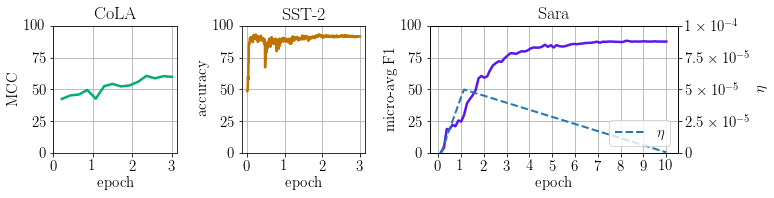

In [16]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(11, 3), 
                        gridspec_kw={'width_ratios': [3, 3, 6]})

smooth_factor = 0 # over what number of epochs to smooth
for task, ax in zip(glue_tasks, axs):
    n_epochs = 3 if task != "Sara" else 10
    metric_name = metrics_raw[task]
    data = pd.read_csv("logs/teacher-{}.csv".format(task), skiprows=1)[metric_name]*100
    info = pd.read_csv("logs/teacher-{}.csv".format(task))
    print(info.head())
    
    if smooth_factor > 0:
        smooth_n = int(len(data)/n_epochs*smooth_factor)
        data_smooth = smooth_series(data, N=smooth_n)
        start = n_epochs*(1 - len(data_smooth)/len(data))
    else:
        data_smooth = data
        start = n_epochs/len(data)
    xs = np.linspace(start=start, stop=n_epochs, num=len(data_smooth))
    ax.plot(xs, data_smooth, c=task_colours[task], lw=2.5, zorder=1)
    
    if task == "Sara":
        ax2 = ax.twinx()
        x_max = len(xs)*0.1
        lrs = [(0.00005*x/x_max if x < x_max else (1-(x-x_max)/(0.9*len(xs)))*0.00005) for x, xx in enumerate(xs)]
        ax2.plot(xs, lrs, label="$\eta$", lw=2, ls="--")
        ax2.set_ylim(0, 0.0001)
        ax2.legend(loc=4)
        ax2.set_ylabel("$\eta$")
        ax2.set_yticks([0, 0.000025, 0.00005, 0.000075, 0.0001])
        ax2.set_yticklabels(["$0$", "$2.5\\times10^{-5}$", "$5\\times10^{-5}$", "$7.5\\times10^{-5}$", "$1\\times10^{-4}$"])
    
    ax.set_ylim(bottom=0, top=100)
    ax.set_title(task)
    ax.set_axisbelow(True)
    ax.grid()
    ax.set_ylabel(metrics[task])
    ax.set_xlabel("epoch")
    ax.set_xticks(range(n_epochs+1))
plt.tight_layout(w_pad=1.2)
plt.show()
fig.savefig("img/teacher-fine-tuning.pdf")

# Class balance in datasets

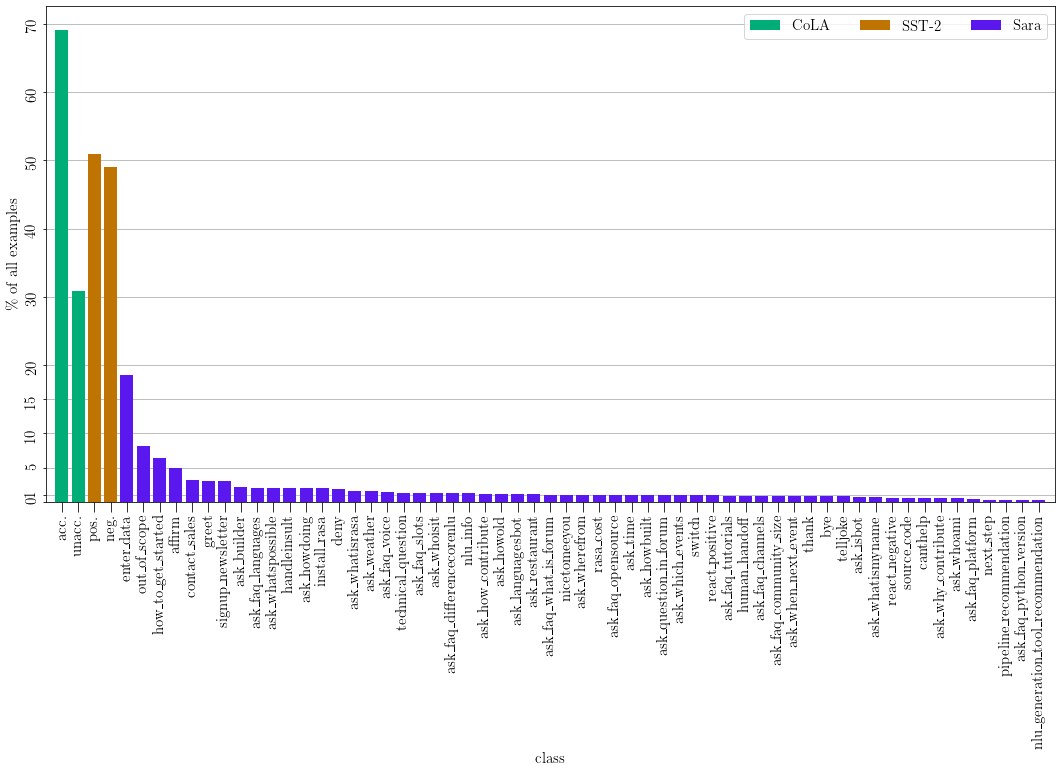

In [11]:
class_counter = 0
fig = plt.figure(figsize=(15, 11))
ax = plt.gca()
xticks = []
xticklabels = []

for task in glue_tasks:
    data = pd.read_csv("predictions/full_predictions-{}.csv".format(task))
    xs = list(np.array(classes[task]) + class_counter)
    xticks += xs
    total_examples = len(data)
    amounts = [100*len(data[data["label"] == c])/total_examples for c in classes[task]]
    sort_indices = np.argsort(amounts)[::-1]
    xticklabels = xticklabels + [*(np.array([class_names[task][c].replace("_", "\\_") for c in classes[task]])[sort_indices])]
    ax.bar(xs, np.array(amounts)[sort_indices], label=task, color=task_colours[task])
    class_counter += len(classes[task])
ax.legend(ncol=3)
ax.set_ylabel("\% of all examples")
ax.set_xlabel("class")
ax.tick_params(axis="x", labelbottom=True, length=10, rotation=90)
ax.set_yticks([0, 1, 5, 10, 15, 20, 30, 40, 50, 60, 70])
ax.tick_params(axis="y", rotation=90)
ax.set_xticks(np.array(xticks))
ax.set_xticklabels(xticklabels, horizontalalignment="center")
ax.grid(axis="y", which="both")
ax.set_axisbelow(True)
ax.set_xlim(-1, class_counter)
plt.tight_layout()
plt.show()
fig.savefig("img/class-balance.pdf")

# Comparing performance of best models

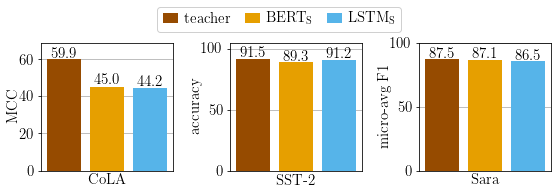

In [31]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(8, 2.8))

for ax, task in zip(axs, glue_tasks):
    bar_counter = 0
    max_score = 0
    results = [best_model_scores[task]["teacher"]]
    colours = [model_colours["teacher"]]
    hatches = [model_type_bar_hatches["main"]]
    ax.text(bar_counter, results[0]+1, "{:.1f}".format(results[0]), ha="center")
    ax.bar(0, results[0], color=colours[0], label="teacher")
    bar_counter += 1
    max_score = max(max_score, results[0])
    for i, main_model_type in enumerate(["BERT", "LSTM"]):
#         all_model_types = [main_model_type] + [(main_model_type + "-" + additional) for additional in model_types["additional"]]
#         colours += [model_colours[main_model_type] for _ in range(len(model_types["additional"])+1)]
#         hatches += [model_type_bar_hatches[model_type] for model_type in (["main"] + model_types["additional"])]
        all_model_types = [main_model_type] # + [(main_model_type + "-" + additional) for additional in model_types["additional"]]
        colours += [model_colours[main_model_type]] # for _ in range(len(model_types["additional"])+1)]
        hatches += [model_type_bar_hatches["main"]] # for model_type in (["main"] + model_types["additional"])]
        for model_type in all_model_types:
            score = best_model_scores[task][model_type]
            results.append(score)
            ax.text(bar_counter, score+1, "{:.1f}".format(score), ha="center")
            bar_counter += 1.0
            max_score = max(max_score, score)
        ax.bar(i+1, results[-1], color=colours[-1], label=P.make_latex_label(main_model_type, role="student"))
    ax.set_ylim(0, max_score*1.15)
    for bar, hatch in zip(ax.patches, hatches): bar.set_hatch(hatch)
    ax.set_ylabel(metrics[task], labelpad=-1)
    ax.set_xlabel(task)
    ax.tick_params(axis="x", labelbottom=False, length=0)
    ax.grid(axis="y")
    ax.set_axisbelow(True)
    ax.legend()
P.unify_legend_outside(fig, axs, legcols=0, position="top")
plt.tight_layout()
plt.show()
fig.savefig("img/best-models-scores.pdf")

# Comparing best models' eval-set prediction entropy

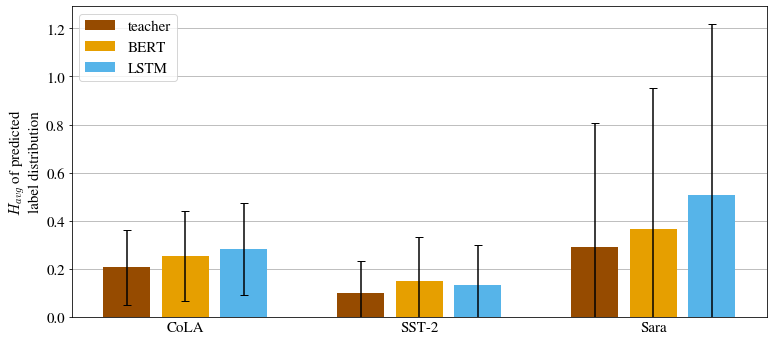

In [75]:
fig = plt.figure(figsize=(11, 5))
ax = plt.gca()
for i, task in enumerate(glue_tasks):
    for j, model_type in enumerate(model_types["main"]):
        ax.bar(j+i*(1+len(model_types["main"])), 
               eval_prediction_entropies[task][model_type]["mean"], 
               color=model_colours[model_type],
               label=(model_type if i == 0 else None),
               yerr=eval_prediction_entropies[task][model_type]["std"], capsize=4)
ax.legend(loc=2)
ax.set_xticks([(1 + i*(1+len(model_types["main"]))) for i in range(3)])
ax.set_ylim(bottom=0)
ax.set_xticklabels(glue_tasks)
ax.tick_params(axis="x", length=0)
ax.grid(axis="y")
ax.set_axisbelow(True)
ax.set_ylabel("$H_{avg}$ of predicted\nlabel distribution")
plt.tight_layout()
plt.show()

# Comparing best models' eval-set prediction average confidence

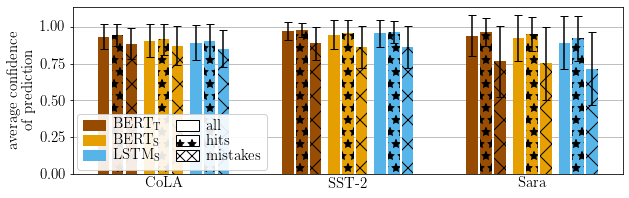

In [49]:
reload(P)
fig = plt.figure(figsize=(9, 3))
ax = plt.gca()
for i, task in enumerate(glue_tasks):
    for j, model_type in enumerate(model_types["main"]):
        data = pd.read_csv("predictions/dev_scored_{}_{}.tsv".format(task, model_type), delimiter="\t")
        confidence = data["certainty_of_pred"].mean()
        confidence_hits = data[data["label"] == data["pred"]]["certainty_of_pred"].mean()
        confidence_misses = data[data["label"] != data["pred"]]["certainty_of_pred"].mean()
        confidence_std = data["certainty_of_pred"].std()
        confidence_hits_std = data[data["label"] == data["pred"]]["certainty_of_pred"].std()
        confidence_misses_std = data[data["label"] != data["pred"]]["certainty_of_pred"].std()
        w = 0.25
        gap = 0.05
        capsize = 4
        ax.bar(j+i*(1+len(model_types["main"]))-w-gap,
               confidence, width=w,
               color=model_colours[model_type],
               label=(P.make_latex_label(model_type) if i == 0 else None),
               yerr=confidence_std, capsize=capsize)
        ax.bar(j+i*(1+len(model_types["main"])),
               confidence_hits, hatch="*", width=w,
               color=model_colours[model_type],
               yerr=confidence_hits_std, capsize=capsize, alpha=.99)
        ax.bar(j+i*(1+len(model_types["main"]))+w+gap,
               confidence_misses, hatch="x", width=w,
               color=model_colours[model_type],
               yerr=confidence_misses_std, capsize=capsize, alpha=.99)
ax.legend(loc=3)
additional_leg_entries = [matplotlib.patches.Patch(facecolor="white", hatch=h, label=l, edgecolor="black")
                          for l, h in zip(["all", "hits", "mistakes"], [None, "*", "xx"])]                          
P.leg_kwargs.update({"handlelength": 1.5})
P.add_to_legend(ax, additional_leg_entries, loc=3, ncol=2, **P.leg_kwargs)

ax.set_xticks([(1 + i*(1+len(model_types["main"]))) for i in range(3)])
ax.set_ylim(bottom=0)
ax.set_xticklabels(glue_tasks)
ax.tick_params(axis="x", length=0)
ax.grid(axis="y", which="both")
ax.set_axisbelow(True)
ax.set_ylabel("average confidence\n of prediction")
plt.tight_layout()
plt.show()
fig.savefig("img/average-confidence.pdf")

# Comparing best models' eval-set prediction confidence distributions

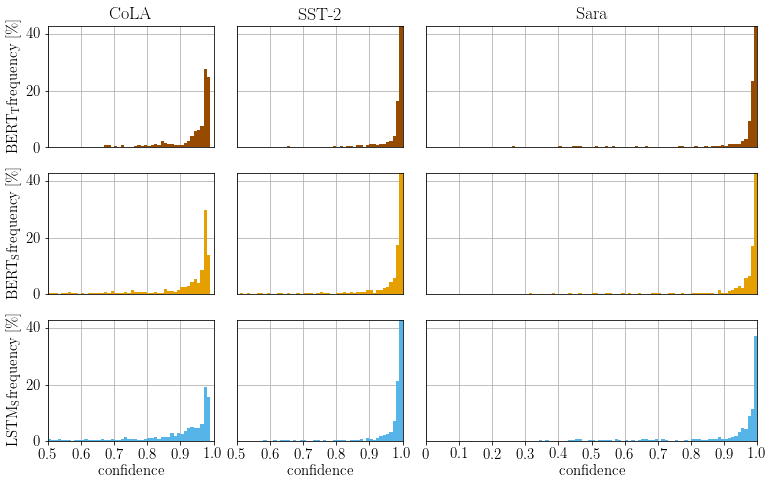

In [66]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(11, 7), sharex="col", sharey=False, 
                        gridspec_kw={'width_ratios': [1, 1, 2]})

for i, task in enumerate(glue_tasks):
    axs[0, i].set_title(task)
    max_heights = []
    for j, model_type in enumerate(model_types["main"]):        
        data = pd.read_csv("predictions/dev_scored_{}_{}.tsv".format(task, model_type), delimiter="\t")
        confidences = data["certainty_of_pred"]
        ax = axs[j, i]
        rects, bins, patches = ax.hist(confidences, bins=100, 
                                       range=(0,1), color=model_colours[model_type], 
                        label=model_type, log=False, density=True)
        ax.set_xlim(0, 1.0)
        if i > 0:
            ax.tick_params(axis="y", length=0, labelleft=False)
        else:
            axs[j, 0].set_ylabel(P.make_latex_label(model_type) + "frequency [\%]")
        if j < 2:
            ax.tick_params(axis="x", length=0)
        else:
            ax.set_xlabel("confidence")
        
        max_height = max(rects)
        max_heights.append(max_height)
        ax.grid(axis="y", which="both")
        ax.grid(axis="x", which="both")
        ax.set_axisbelow(True)
        if task == "Sara":
            ax.set_xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.])
            ax.set_xticklabels([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.])
        else:
            ax.set_xticks([0.5, 0.6, 0.7, 0.8, 0.9, 1.])
            ax.set_xticklabels([0.5, 0.6, 0.7, 0.8, 0.9, 1.])
            ax.set_xlim(0.5, 1.0)
        ax.set_ylim(0, 43)
#     for k, _ in enumerate(model_types["main"]):
#         axs[j, k].set_ylim(0, max(max_heights)*1.05)
#         axs[j, k].set_ylim(0, 43)
plt.tight_layout(w_pad=0.3, h_pad=0.2)
plt.show()

# Correlation of models' confidences

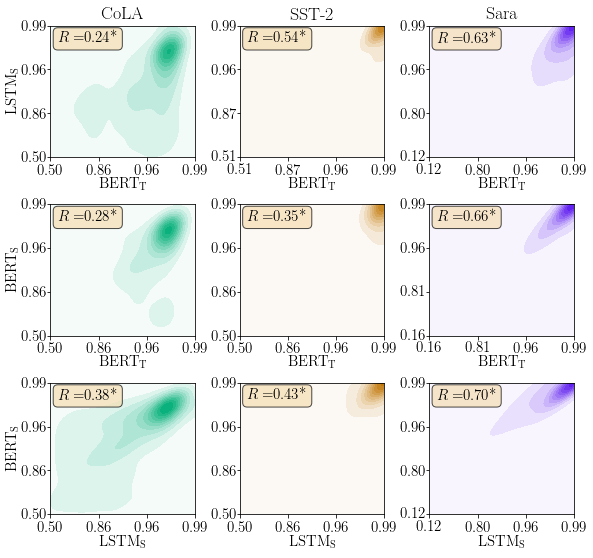

In [4]:
take_log = True
prob_log_limit = 0.99
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(8.5, 8), sharex=False, sharey=False)
pairs = [("teacher", "LSTM"), ("teacher", "BERT"), ("LSTM", "BERT")]
c = [0.0]*3 + [0.3]
for i, task in enumerate(glue_tasks):
    data = pd.read_csv("predictions/full_predictions-{}.csv".format(task))
    axs[0, i].set_title(task)
    for j, pair in enumerate(pairs):
        ax = axs[j, i]
        xs = data["confidence_{}".format(pair[0])]
        ys = data["confidence_{}".format(pair[1])]
        R, p = pearsonr(xs, ys)
        text = "$R = ${:.2f}".format(R) + ("*" if p < 0.05 else "")
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.7)
        ax.text(0.05, 0.95, text, transform=ax.transAxes, verticalalignment='top', bbox=props)
        if take_log:
            xs = np.minimum(xs, prob_log_limit)
            ys = np.minimum(ys, prob_log_limit)
            xs = np.log(1-xs)*-1
            ys = np.log(1-ys)*-1
#         ax.plot(xs, ys, marker=".", color=c, markeredgewidth=0, linewidth=0, markersize=8)
        sns.kdeplot(xs, ys, ax=ax, shade=True, shade_lowest=True, cmap=task_cmaps[task], gridsize=500)
        bottom = min(min(xs), min(ys))
        top = max(max(xs), max(ys))
        ax.set_xlim(bottom, top)
        ax.set_ylim(bottom, top)
        if i == 0:
            ax.set_ylabel(P.make_latex_label(pair[1]), labelpad=1.0)
        else:
            ax.set_ylabel(None)
        ax.tick_params(axis="y", pad=-0.5)
#         if j == 2:
        ax.set_xlabel(P.make_latex_label(pair[0]), labelpad=3.0)
#         else:
#             ax.set_xlabel(None)
        if take_log:
            ticks = [bottom, bottom + (-np.log(1-prob_log_limit) - bottom)/3, 
                     bottom + 2*(-np.log(1-prob_log_limit) - bottom)/3, -np.log(1-prob_log_limit)]
            ticklabels = ["{:.2f}".format(-np.exp(-t)+1) for t in ticks]
            ax.set_xticks(ticks)
            ax.set_yticks(ticks)
            ax.set_xticklabels(ticklabels)
            ax.set_yticklabels(ticklabels)
            
plt.tight_layout(w_pad=0.2, h_pad=0.35)
plt.show()
fig.savefig("img/confidence-correlation.pdf")

# Correlation between sentence length and confidences

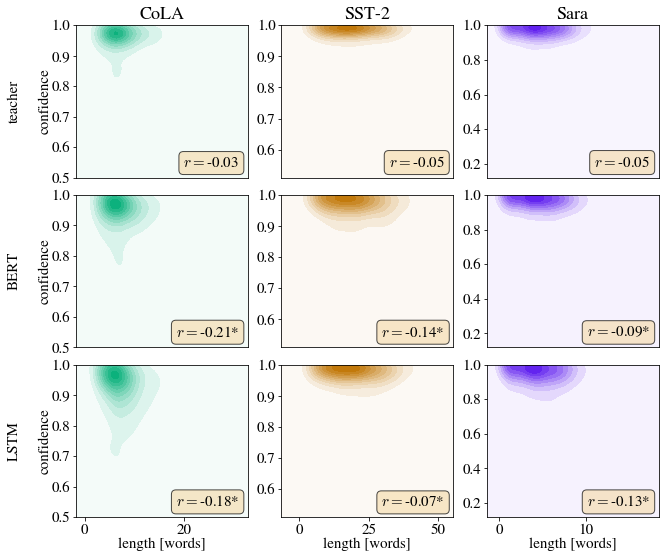

In [8]:
take_log = False
prob_log_limit = 0.99
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(9.5, 8), sharex="col", sharey="col")
alpha = 0.3
for i, task in enumerate(glue_tasks):
    data = pd.read_csv("predictions/full_predictions-{}.csv".format(task))
    axs[0, i].set_title(task)
    for j, model_type in enumerate(model_types["main"]):
        ax = axs[j, i]
        ys = data["confidence_{}".format(model_type)]
        xs = data["sentence"].apply(lambda s: len(s.split()))
        R, p = pearsonr(xs, ys)
        text = "$r = ${:.2f}".format(R) + ("*" if p < 0.05 else "")
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.7)
        ax.text(0.95, 0.05, text, transform=ax.transAxes, verticalalignment='bottom', horizontalalignment='right', bbox=props)
        if take_log:
            ys = np.minimum(ys, prob_log_limit)
            ys = np.log(1-ys)*-1
#         ax.plot(xs, ys, marker=".", color=[*model_colours[model_type], alpha], markeredgewidth=0, linewidth=0, markersize=8)
        sns.kdeplot(xs, ys, ax=ax, shade=True, shade_lowest=True, cmap=task_cmaps[task], gridsize=200)
        bottom = min(ys)
        top = max(ys)
        ax.set_ylim(bottom, 1.0)
        if i == 0: 
            ax.set_ylabel(model_type + "\n\nconfidence", labelpad=0)
        else:
            ax.set_ylabel(None)
        ax.tick_params(axis="y", pad=2)
        if j == 2: 
            ax.set_xlabel("length [words]", labelpad=0)
        else:
            ax.set_xlabel(None)
            ax.tick_params(axis="x", length=0)
        if take_log:
            ticks = [bottom, bottom + (-np.log(1-prob_log_limit) - bottom)/3, 
                     bottom + 2*(-np.log(1-prob_log_limit) - bottom)/3, -np.log(1-prob_log_limit)]
            ticklabels = ["{:.2f}".format(-np.exp(-t)+1) for t in ticks]
            ax.set_yticks(ticks)
            ax.set_yticklabels(ticklabels)
            
plt.tight_layout(w_pad=0.1, h_pad=0.8)
plt.show()

# Correlation between sentence length and correctness

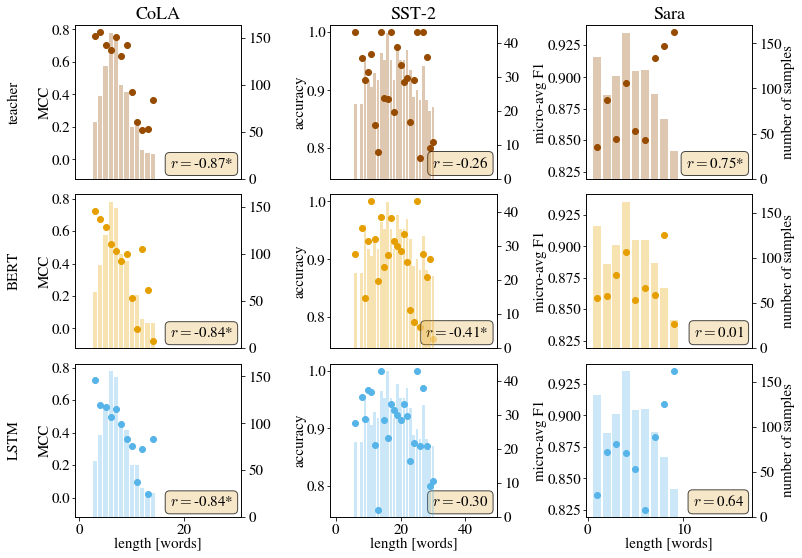

In [189]:
take_log = False
prob_log_limit = 0.99
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(11.5, 8), sharex="col", sharey="col")
alpha = 0.3
for i, task in enumerate(glue_tasks):
    data = pd.read_csv("predictions/full_predictions-{}.csv".format(task))
    lengths = data["sentence"].apply(lambda s: len(s.split()))
    data = data.assign(length=lengths)
    lengths = range(1, max(lengths)+1)
    axs[0, i].set_title(task)
    for j, model_type in enumerate(model_types["main"]):
        ax = axs[j, i]
        xs = lengths
        ys = []
        ys1 = []
        for l in lengths:
            rows = data[data["length"] == l]
            if len(rows) >= 20:
                score = compute_score(rows["label"], rows["pred_" + model_type], task)
                ys.append(score)
                ys1.append(len(rows))
            else:
                ys.append(None)
                ys1.append(0)
        R, p = pearsonr(np.array(xs)[np.array(ys) != None], np.array(ys)[np.array(ys) != None])
        text = "$r = ${:.2f}".format(R) + ("*" if p < 0.05 else "")
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.7)
        ax.text(0.95, 0.05, text, transform=ax.transAxes, verticalalignment='bottom', horizontalalignment='right', bbox=props)
        ax.plot(xs, ys, marker=".", color=model_colours[model_type], linewidth=0, markersize=12)
        ax2 = ax.twinx()
        ax2.bar(xs, ys1, color=[*model_colours[model_type], alpha])
        if i == 0: 
            ax.set_ylabel(model_type + "\n\n{}".format(metrics[task]), labelpad=0)
        else:
            ax.set_ylabel("{}".format(metrics[task]), labelpad=0)
        if i == 2:
            ax2.set_ylabel("number of samples", labelpad=0)
        ax.tick_params(axis="y", pad=1)
        if j == 2: ax.set_xlabel("length [words]", labelpad=0) 
        else: ax.tick_params(axis="x", length=0)
plt.tight_layout(w_pad=1.5, h_pad=0.5)
plt.show()